In [ ]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import infercnvpy as cnv
import matplotlib.pyplot as plt
from pathlib import Path
from scripts.utils import load_from_pickle, save_to_pickle, get_sample_ids
import warnings
warnings.filterwarnings('ignore')

In [ ]:
adata = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

In [ ]:
adata_concat = ad.concat(adata)

# Extract the string before '-' or '_' in each entry
adata_concat.obs['phenotype'] = [entry.split('-')[0].split('_')[0] for entry in adata_concat.obs['sample_id']]

In [ ]:
adata_concat

In [ ]:
## Merge gene features (var) with chromosomal coordinates before this!
cnv.io.genomic_position_from_gtf('./gencode.v43.annotation.gtf', adata_concat)

In [ ]:
## create an anndata object of BPH luminal epithelial cells that will be used as ref.

ref_cat = {'BPH_688':['5','6'],
            'BPH_665':['2'],
            'BPH_651':['1']}

subset_data = []

for idx, row in adata_concat.obs.iterrows():
    sample_id = row['sample_id']
    cluster = row['joint_leiden_clusters']
    if sample_id in ref_cat and cluster in ref_cat[sample_id]:
        subset_data.append(row)

df_subset = pd.DataFrame(subset_data)
ref_subset = adata_concat[df_subset.index]


In [ ]:
infercnv_dict = {}
n_samples = len(samples)
count = 1
for sample in samples:
    if 'BPH' not in sample:

        adata_subset = adata_concat[adata_concat.obs['sample_id']==sample]

        adata_subset = ad.concat([adata_subset,ref_subset],join='outer')

        if (adata_subset.var_names == ref_subset.var_names).all():
            adata_subset.var = ref_subset.var.copy()
        
        # Normalize separately to ensure even, comparable distributions
        adata_subset.X = adata_subset.layers['counts']
        sc.pp.normalize_total(adata_subset)
        sc.pp.log1p(adata_subset)


        cnv.tl.infercnv(
        adata_subset,
        reference_key="phenotype",
        reference_cat=['BPH'],
        window_size=101,
        )

        infercnv_dict[sample] = adata_subset
        print('Sample ' +sample+ ' processed: '+ str(count)+'/'+str(n_samples))
    count+=1

... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical
... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical
... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical
... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical
... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical
... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical
... 

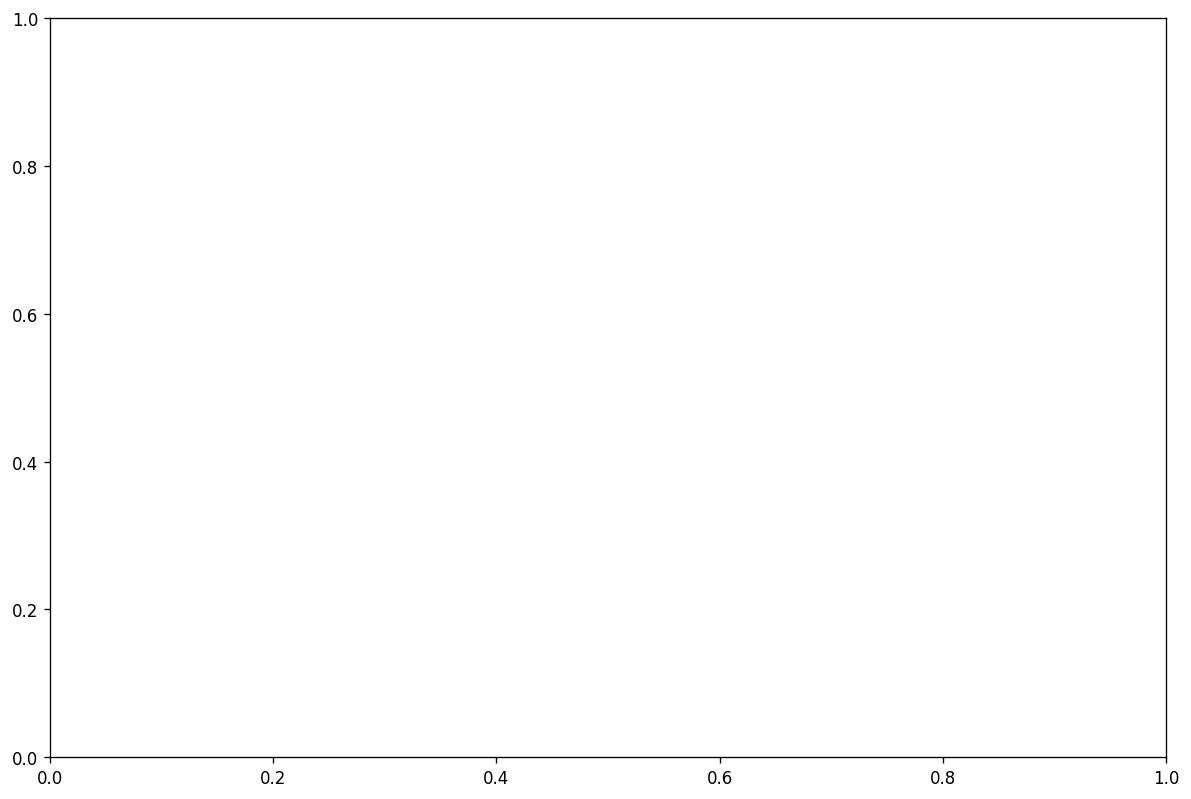

<Figure size 1200x800 with 0 Axes>

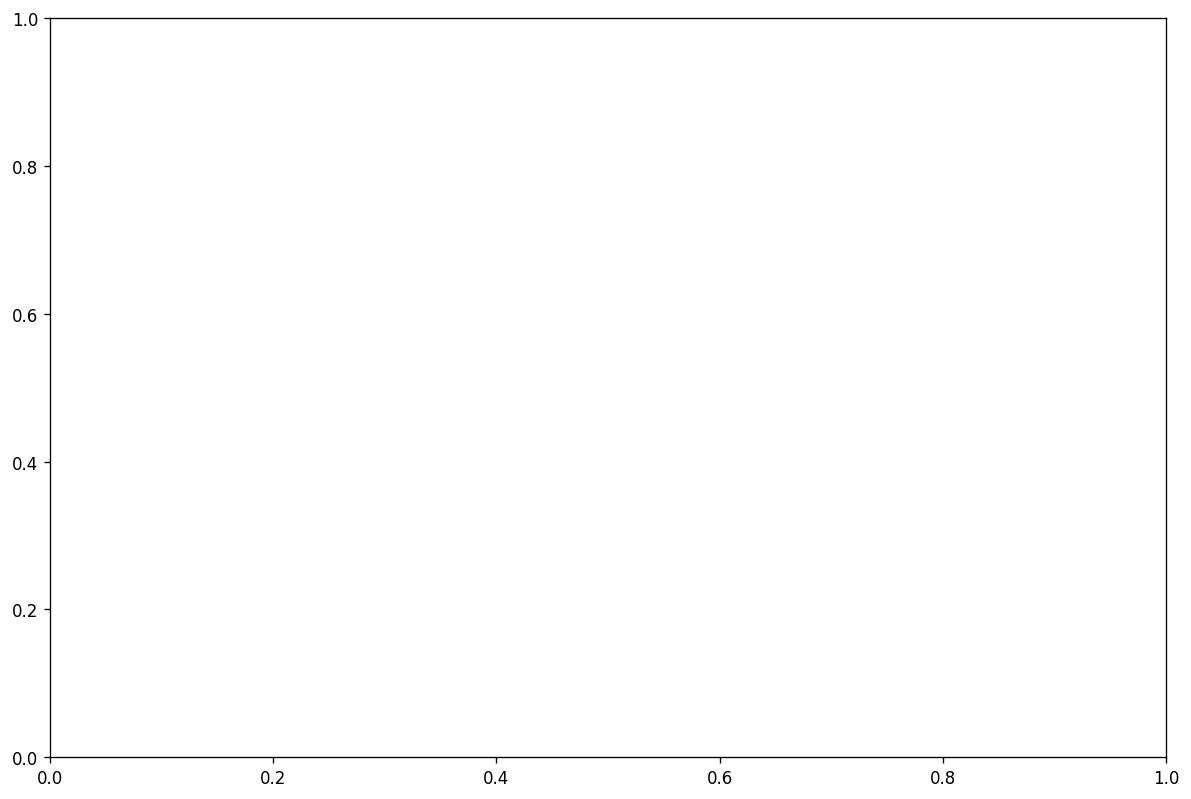

<Figure size 1200x800 with 0 Axes>

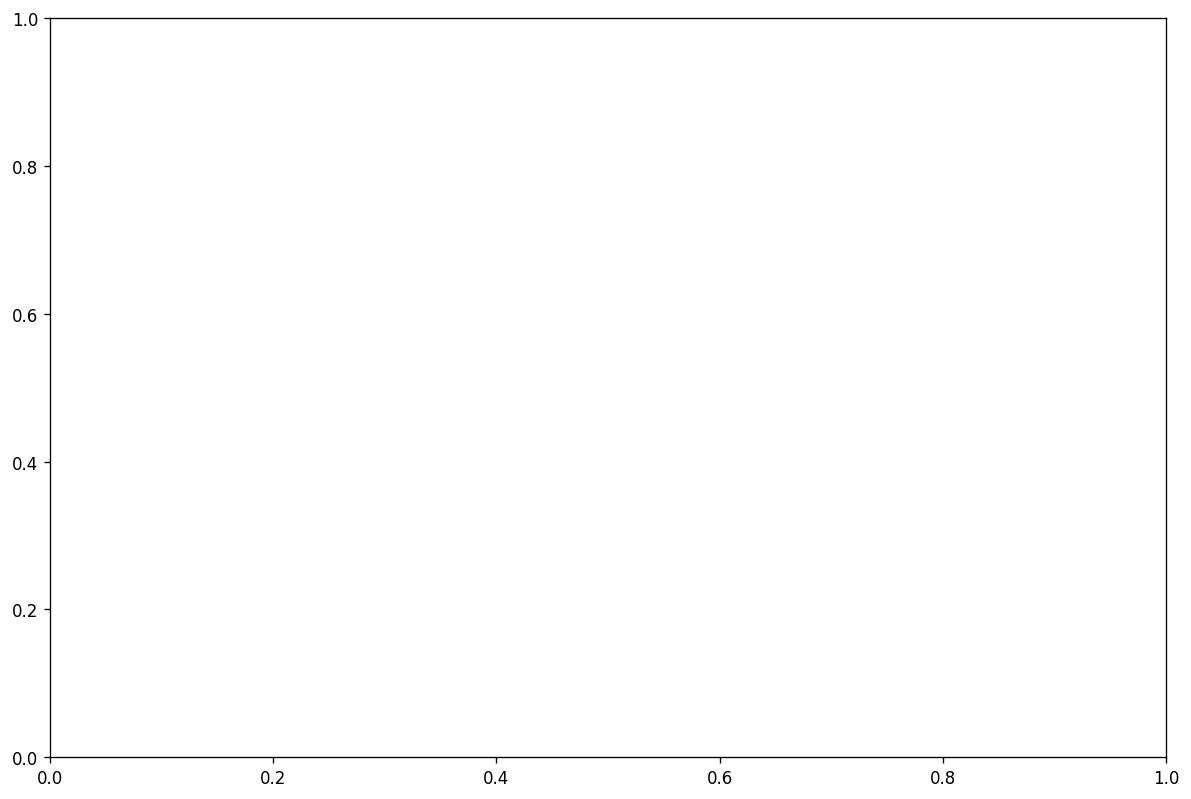

<Figure size 1200x800 with 0 Axes>

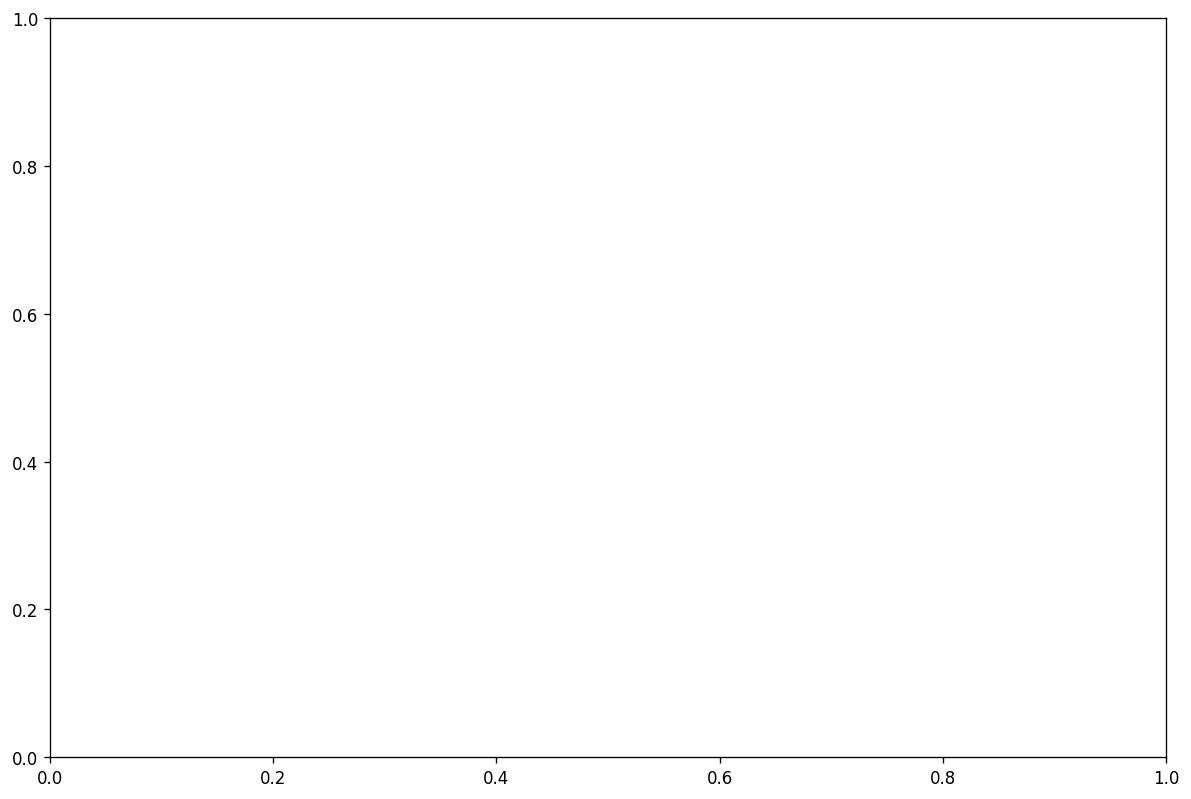

<Figure size 1200x800 with 0 Axes>

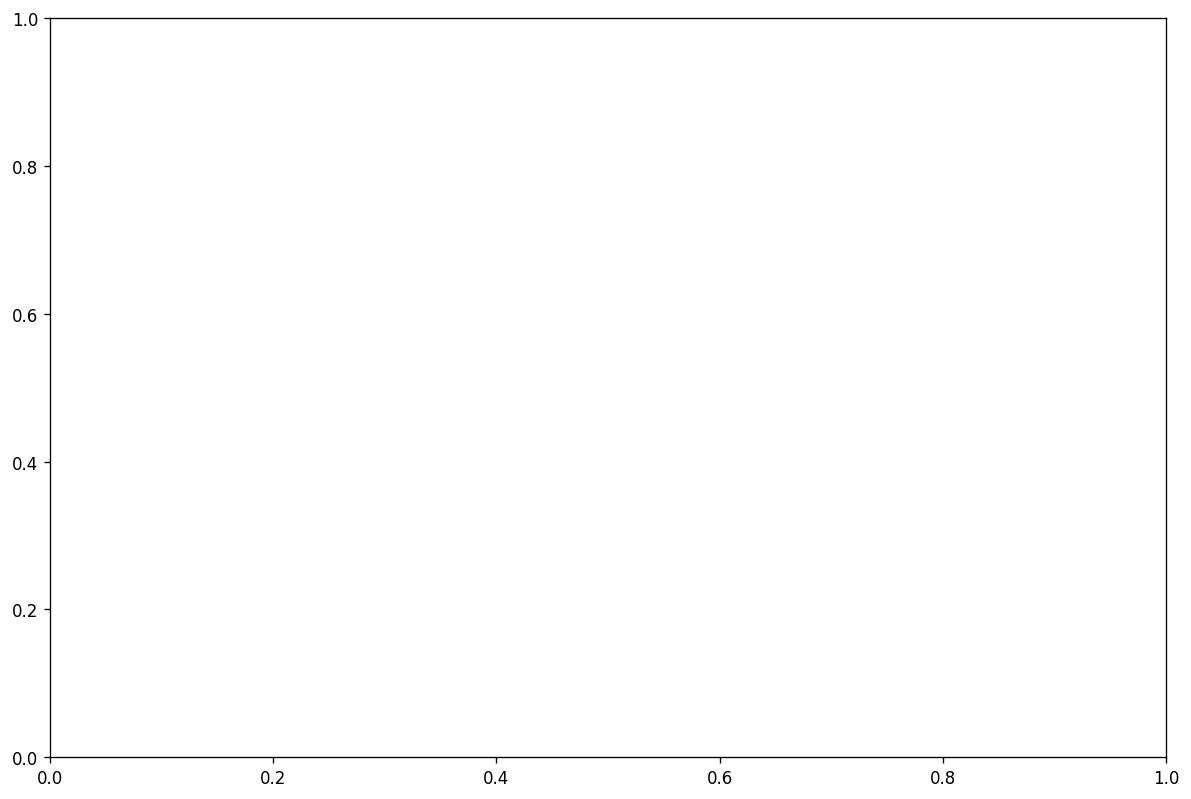

<Figure size 1200x800 with 0 Axes>

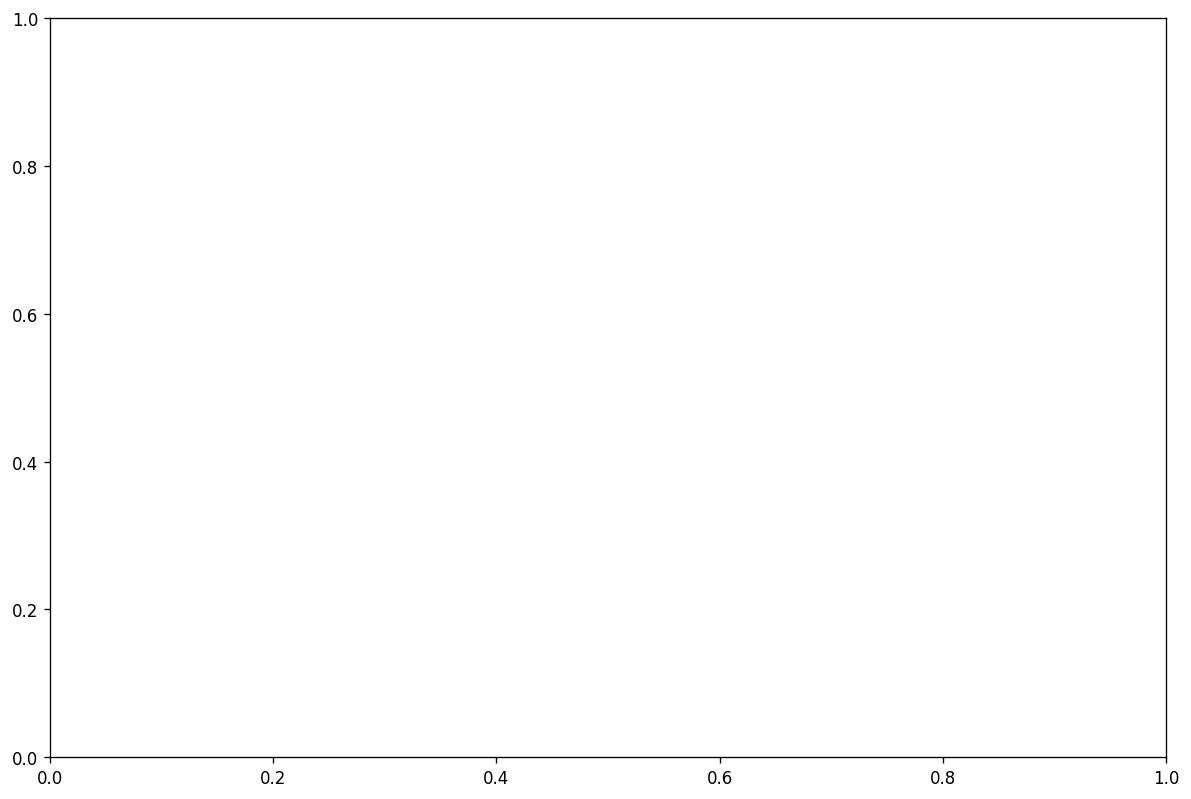

<Figure size 1200x800 with 0 Axes>

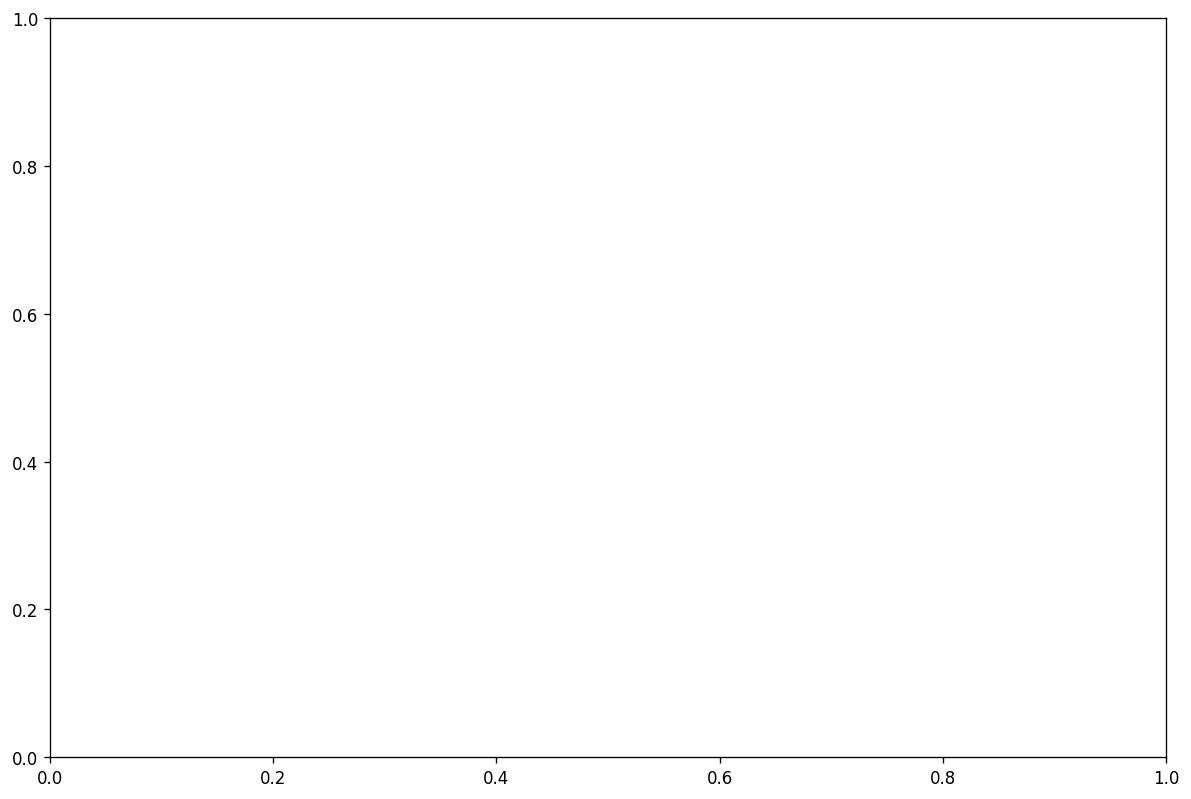

<Figure size 1200x800 with 0 Axes>

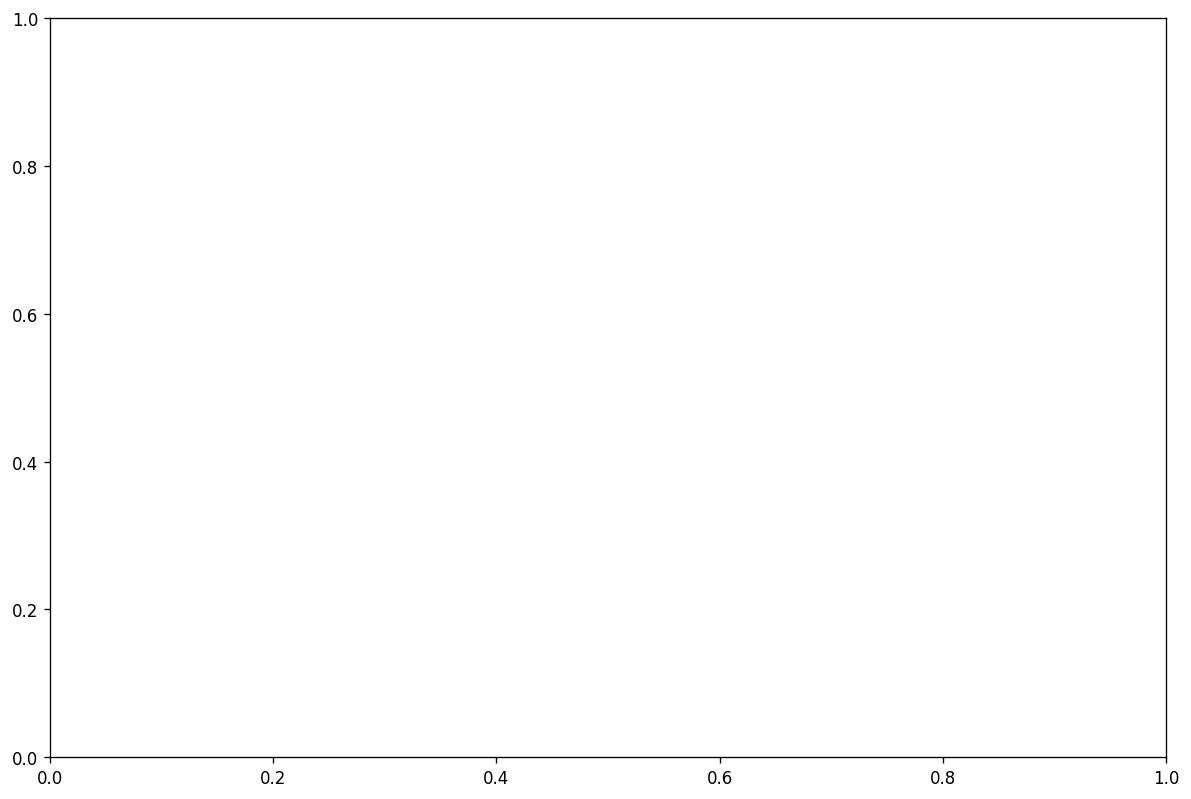

<Figure size 1200x800 with 0 Axes>

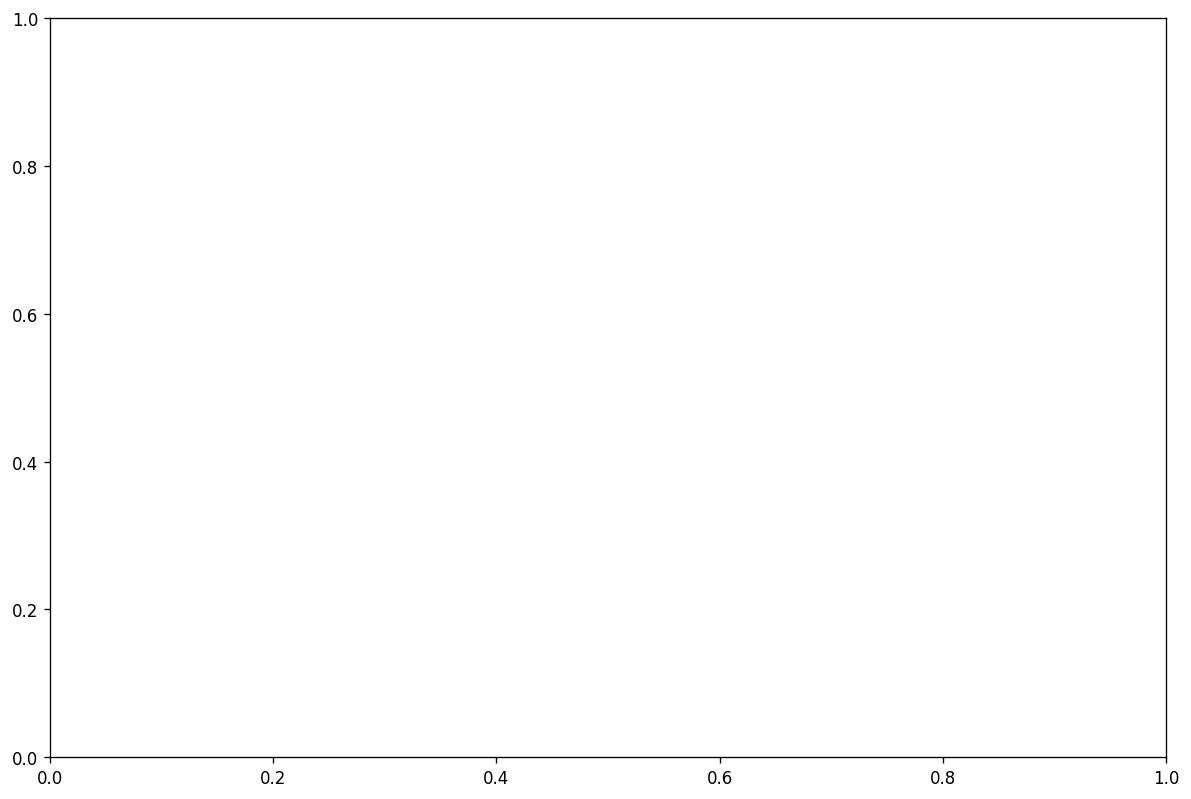

<Figure size 1200x800 with 0 Axes>

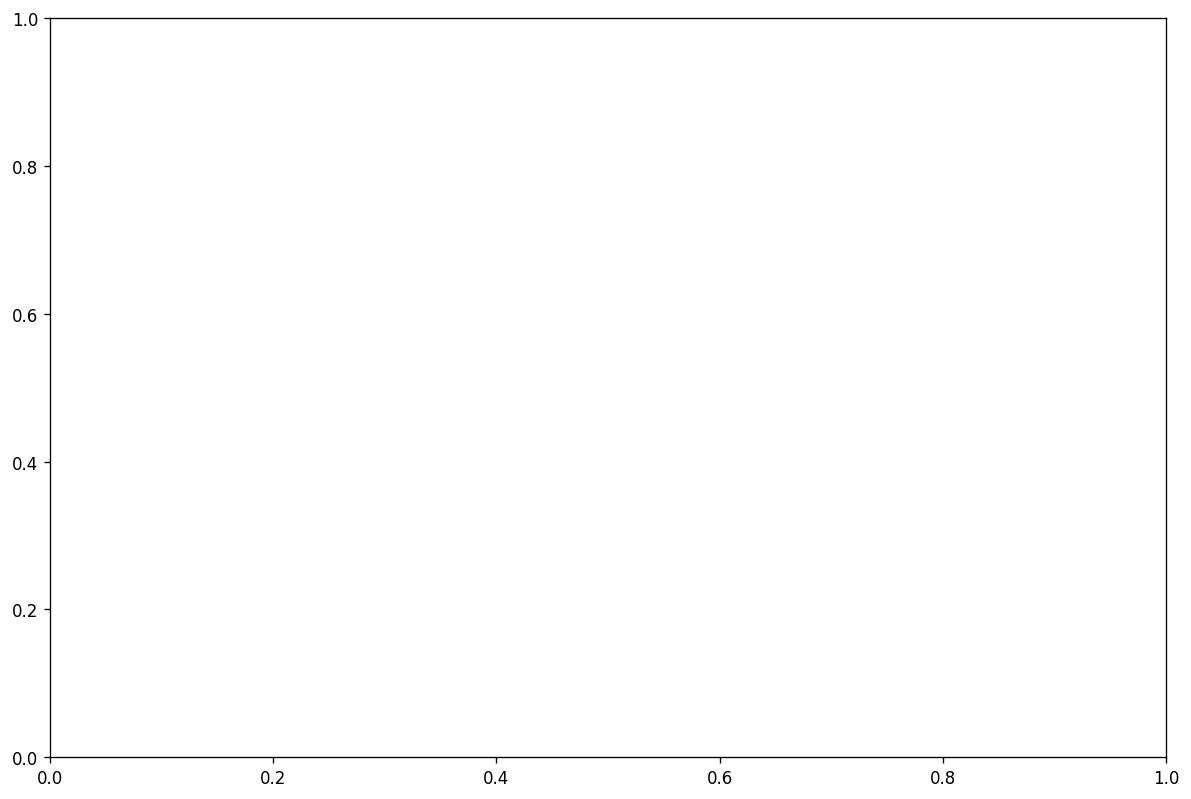

<Figure size 1200x800 with 0 Axes>

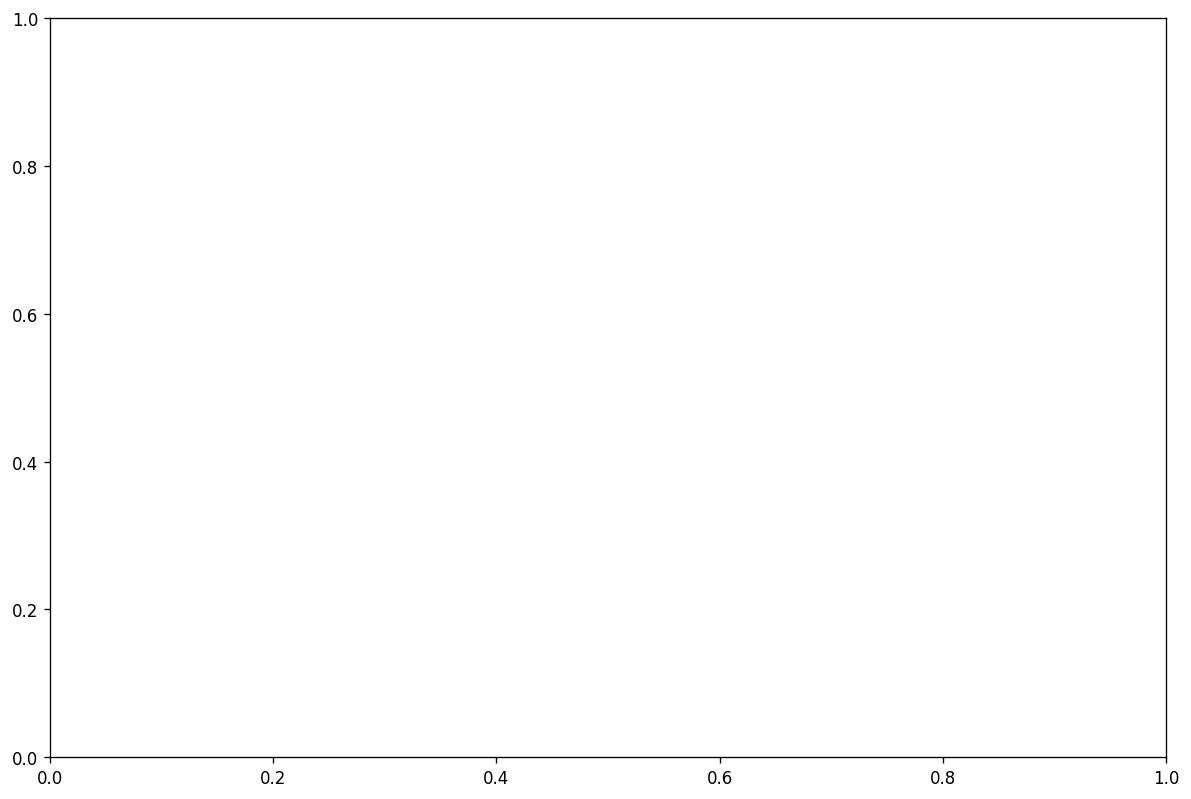

<Figure size 1200x800 with 0 Axes>

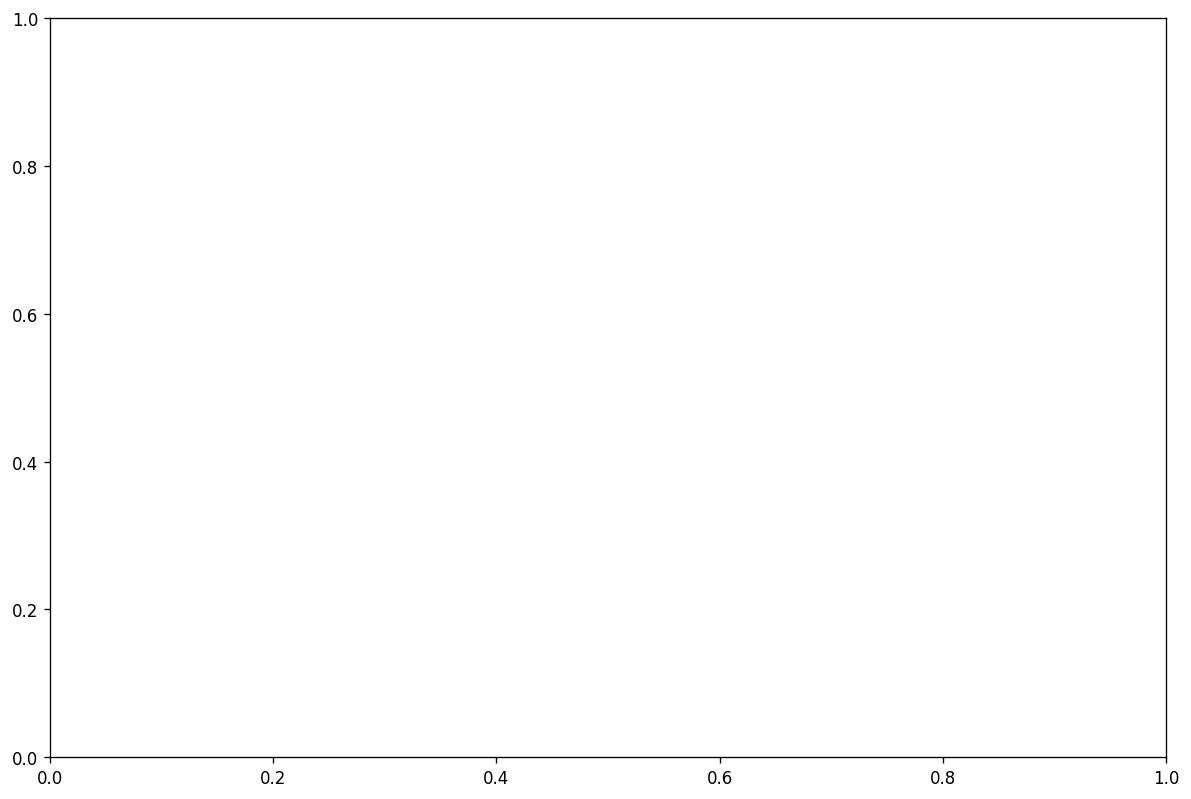

<Figure size 1200x800 with 0 Axes>

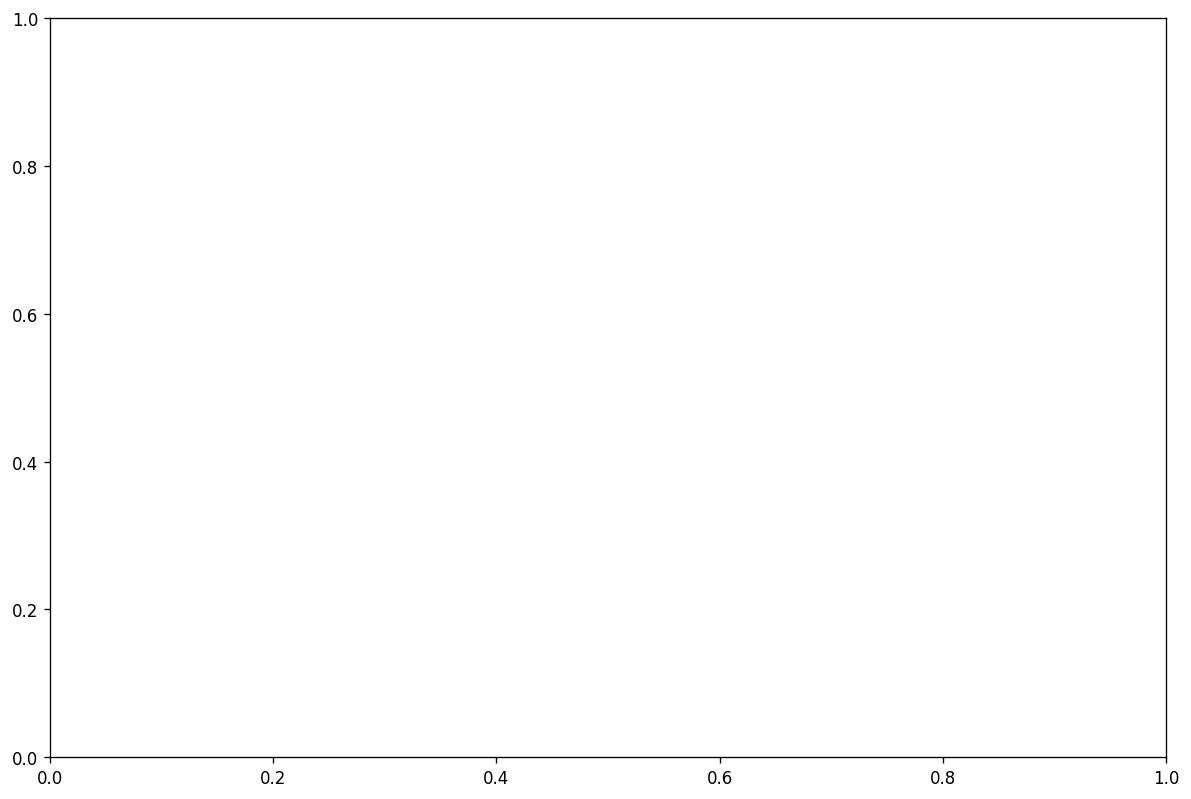

<Figure size 1200x800 with 0 Axes>

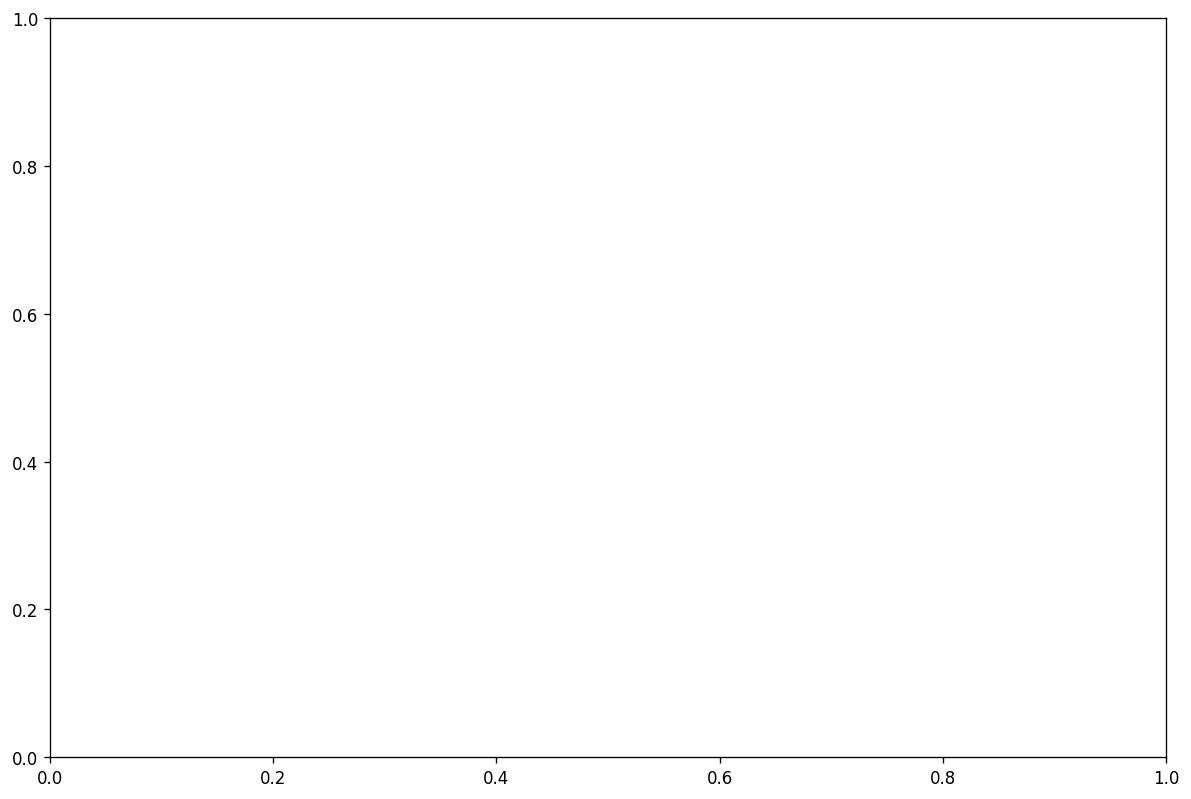

<Figure size 1200x800 with 0 Axes>

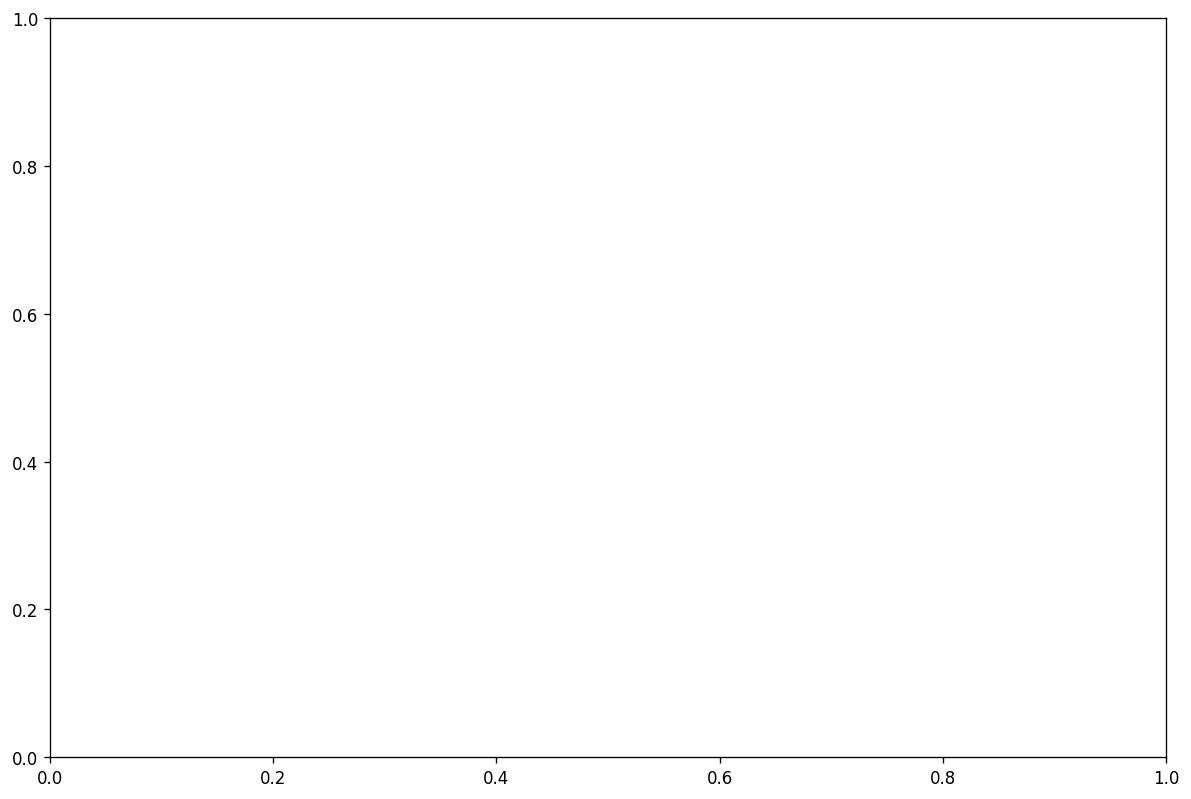

<Figure size 1200x800 with 0 Axes>

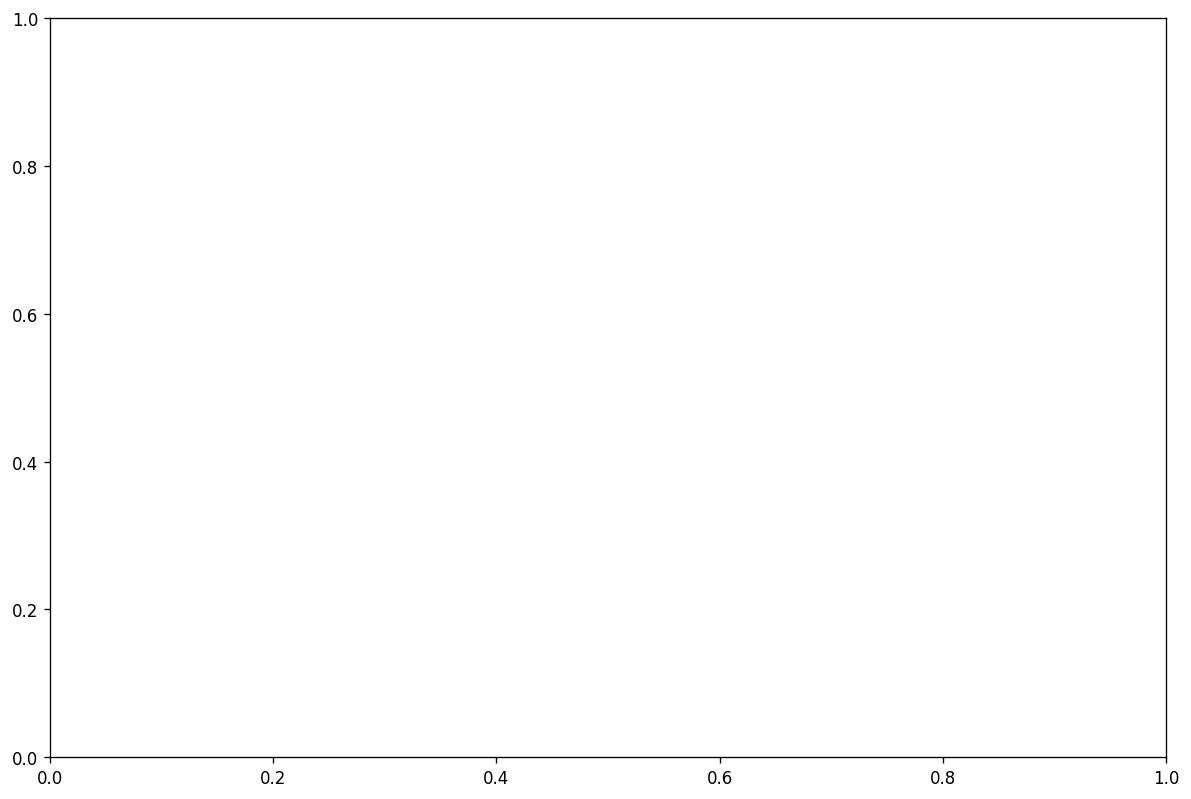

<Figure size 1200x800 with 0 Axes>

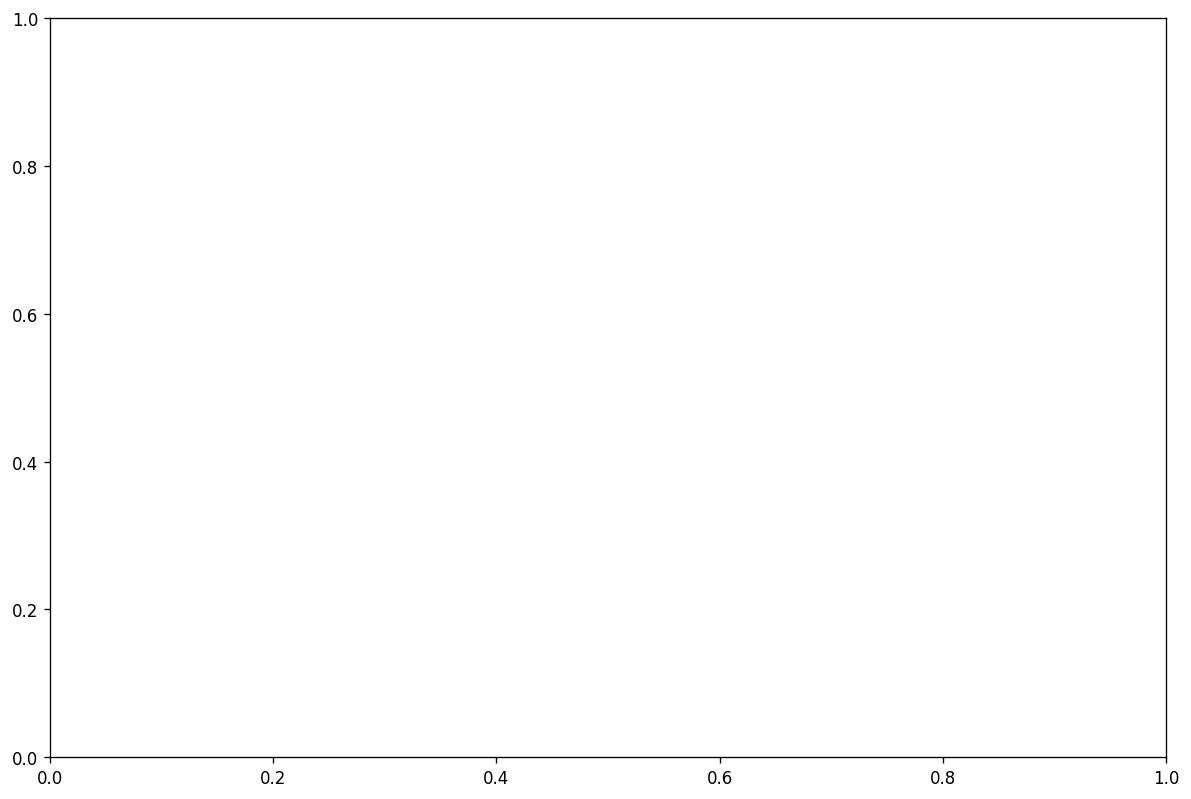

<Figure size 1200x800 with 0 Axes>

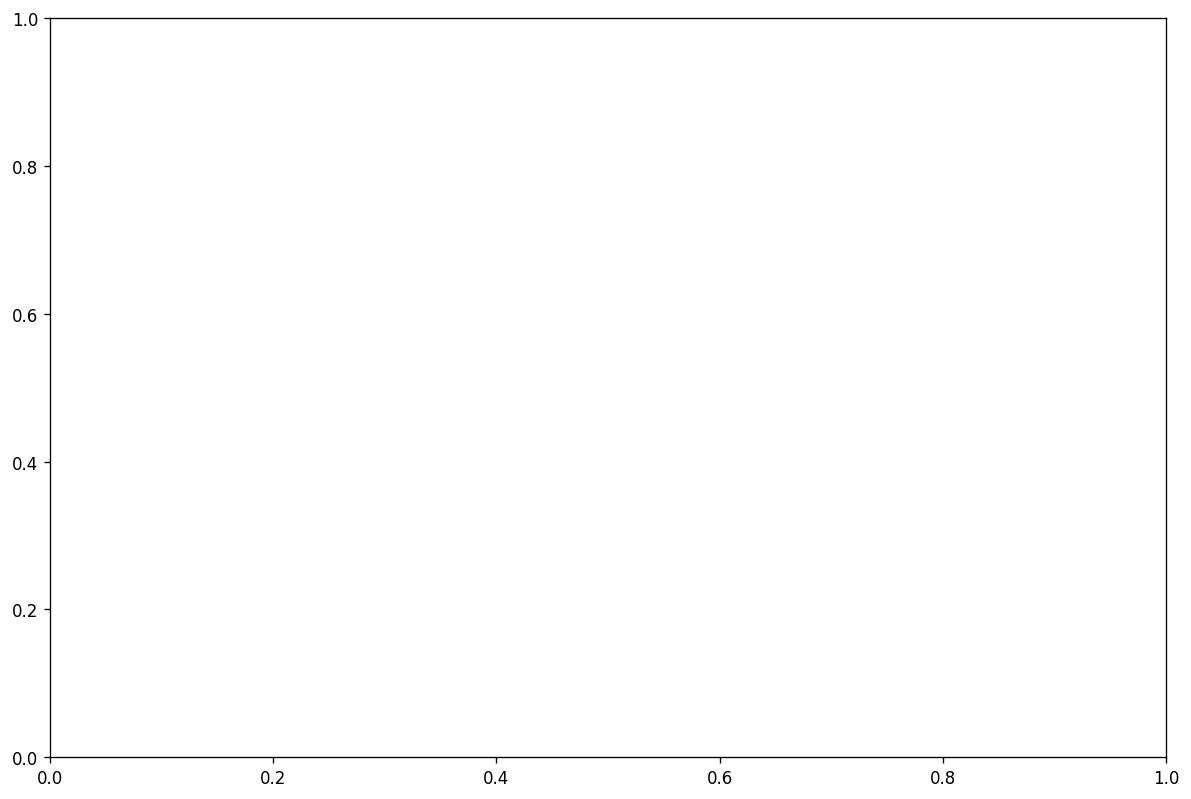

<Figure size 1200x800 with 0 Axes>

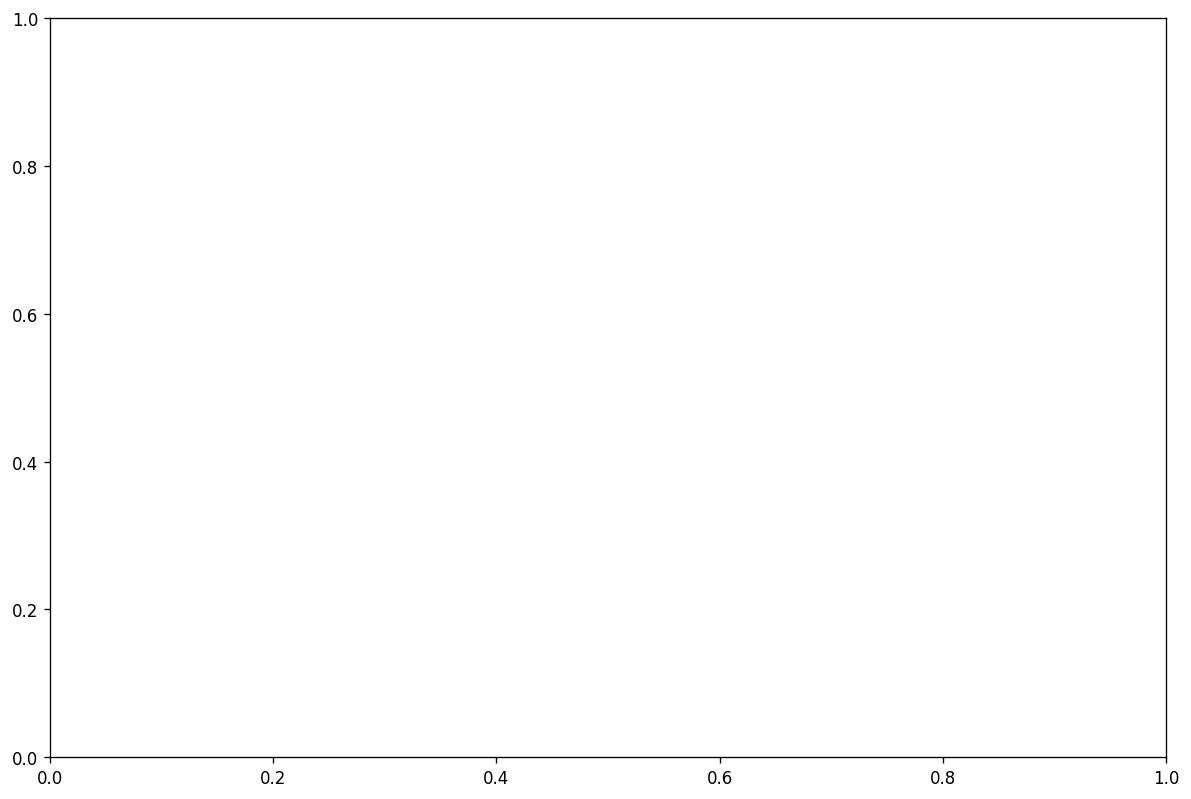

<Figure size 1200x800 with 0 Axes>

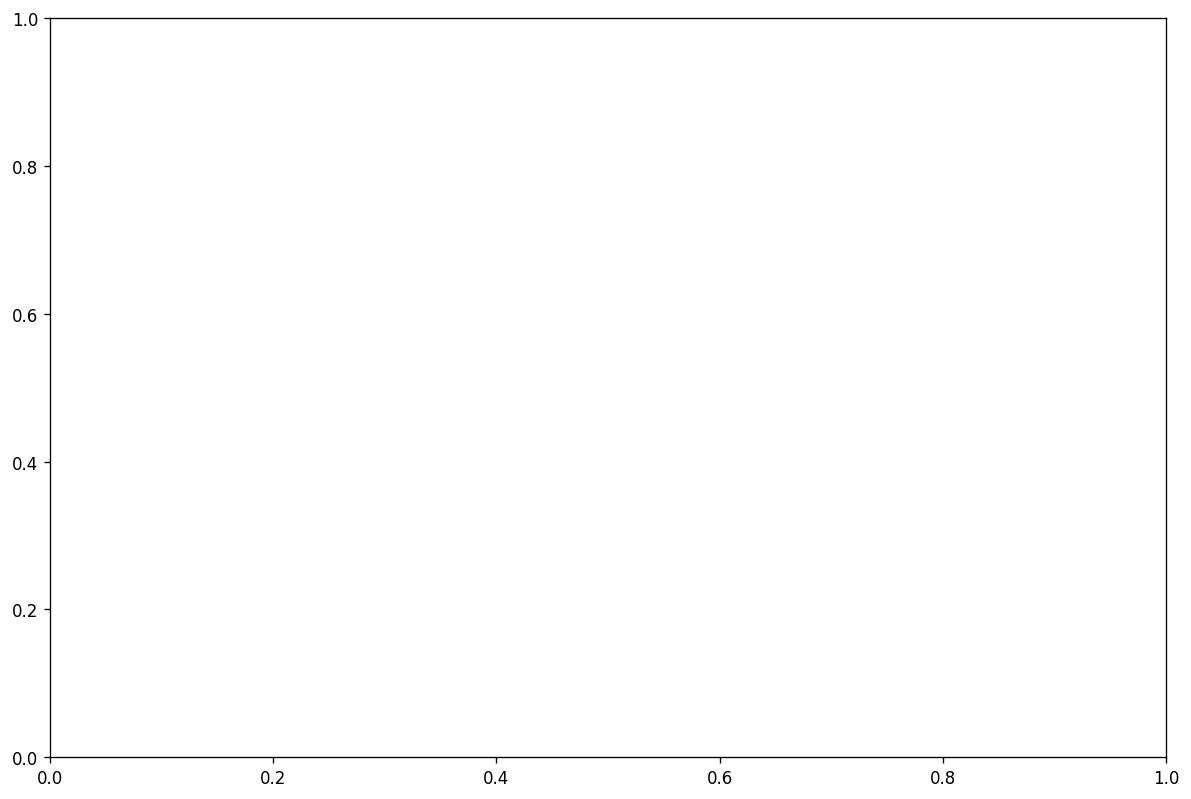

<Figure size 1200x800 with 0 Axes>

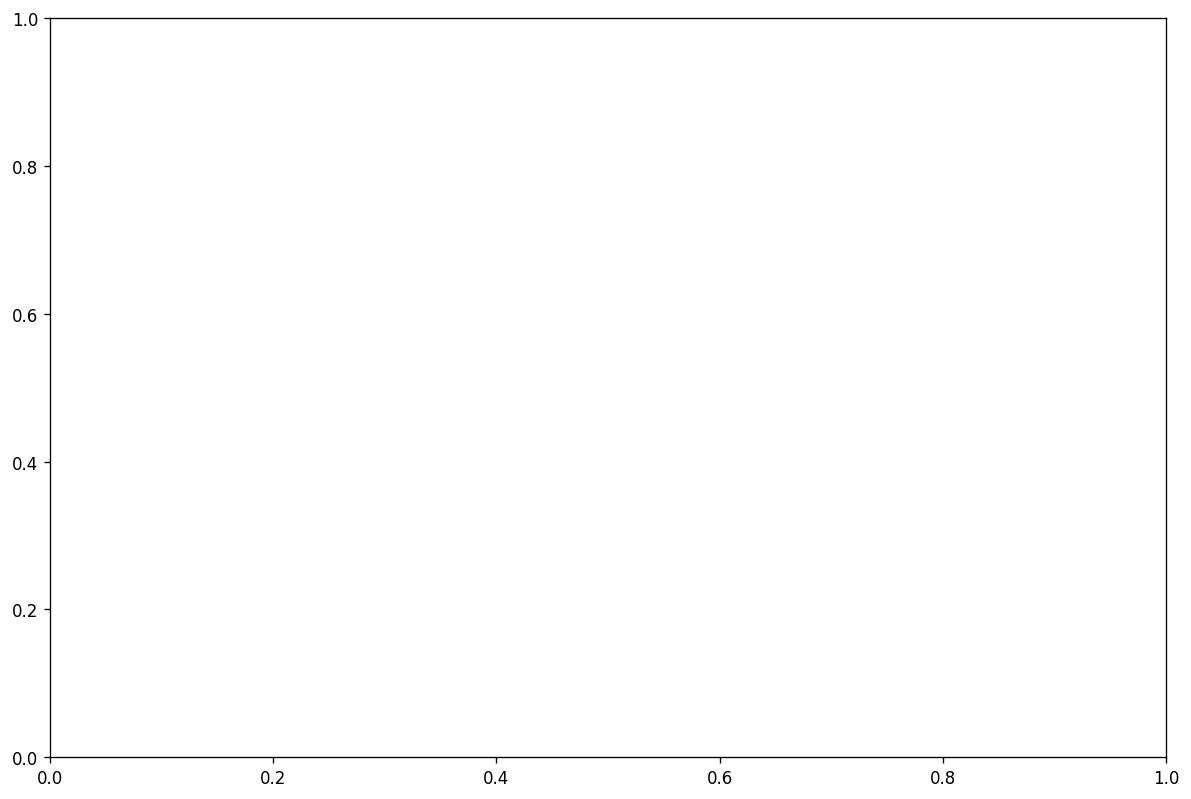

<Figure size 1200x800 with 0 Axes>

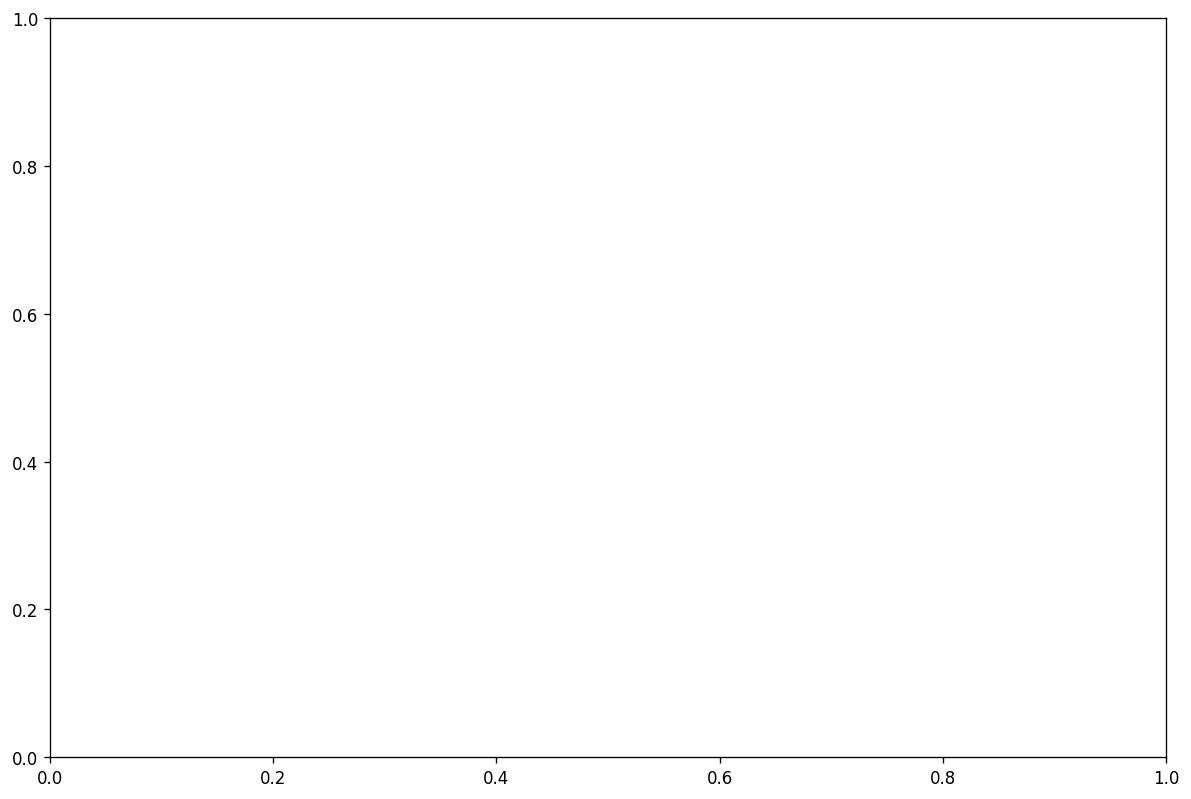

<Figure size 1200x800 with 0 Axes>

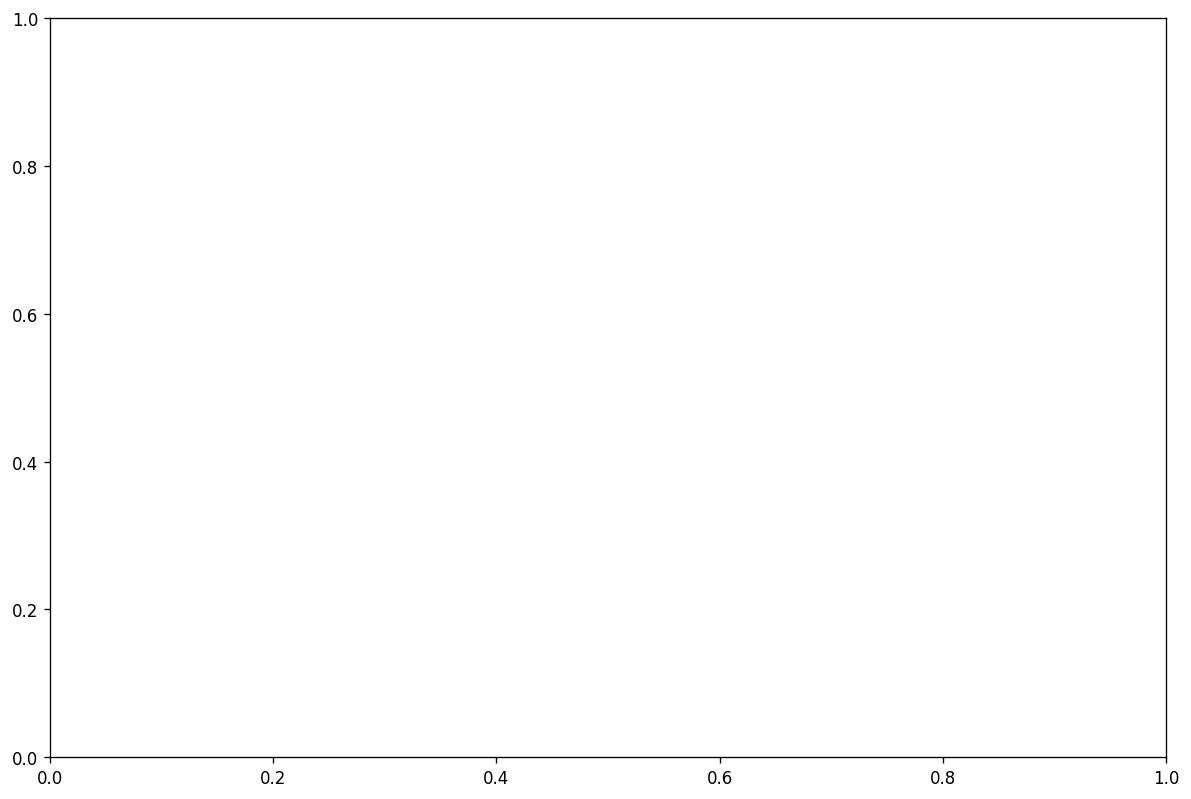

<Figure size 1200x800 with 0 Axes>

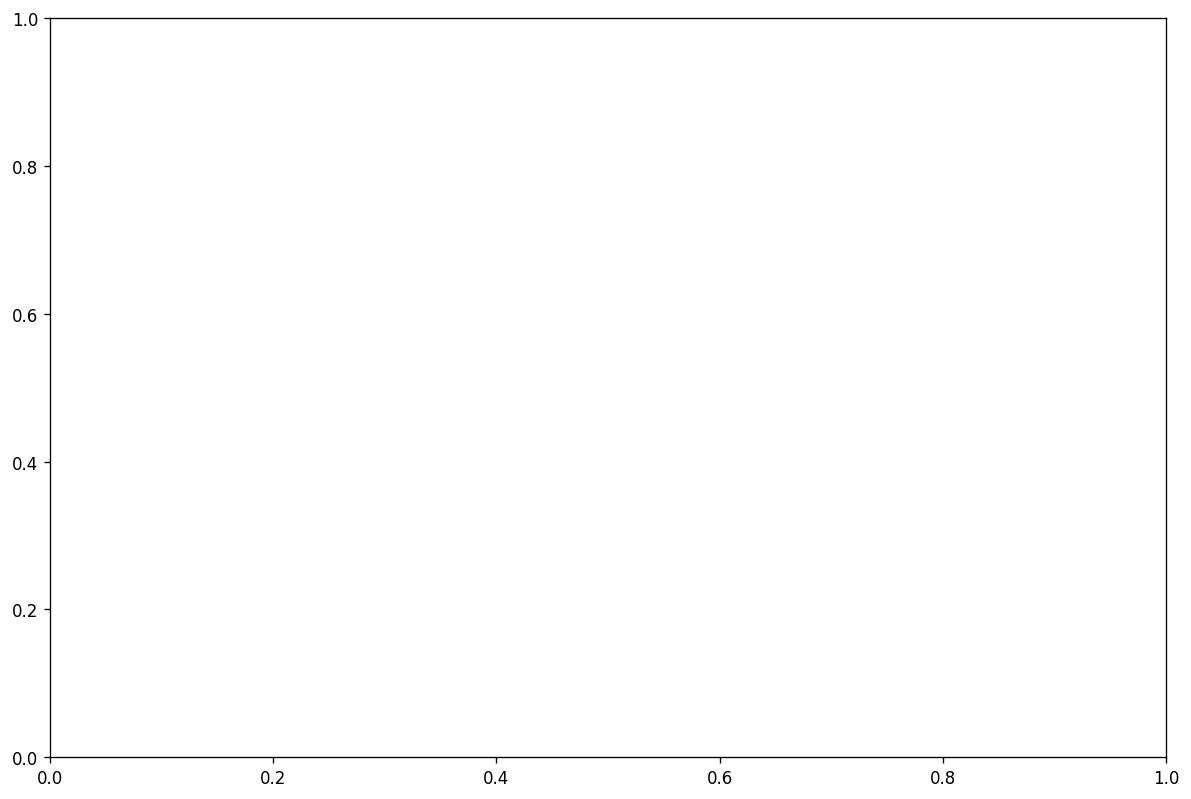

<Figure size 1200x800 with 0 Axes>

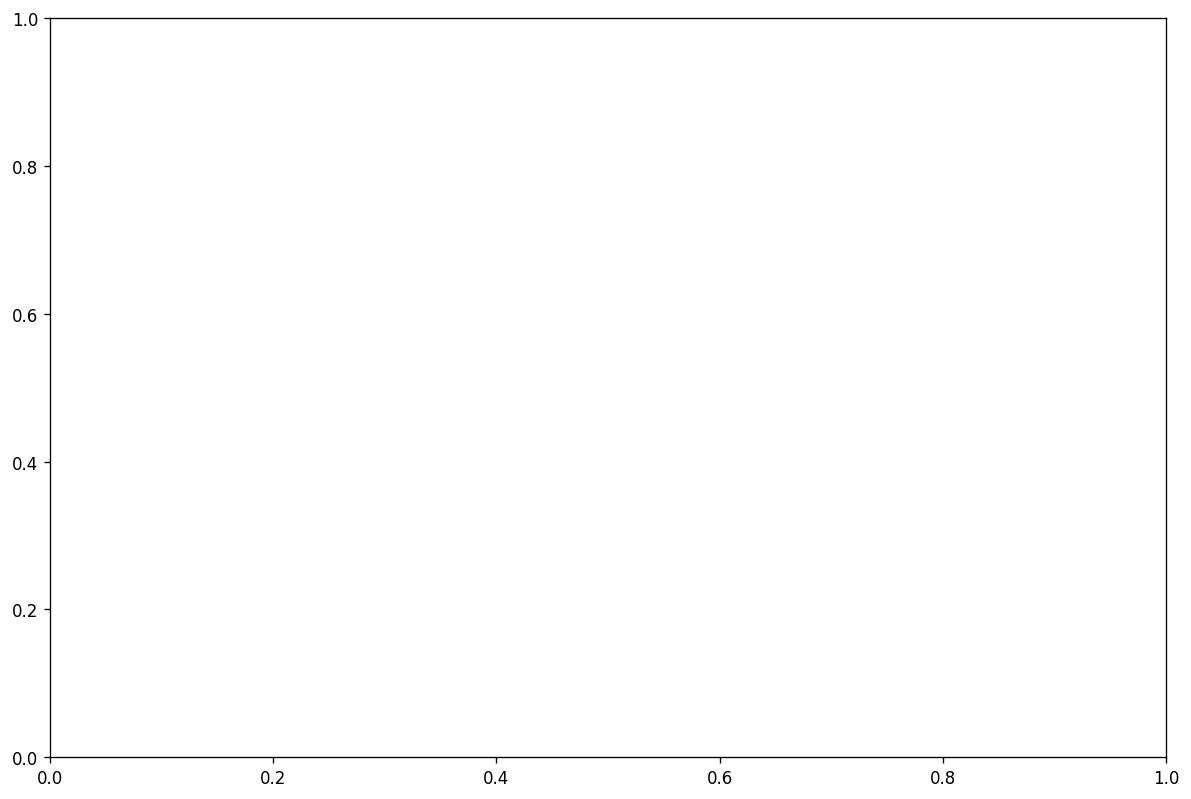

<Figure size 1200x800 with 0 Axes>

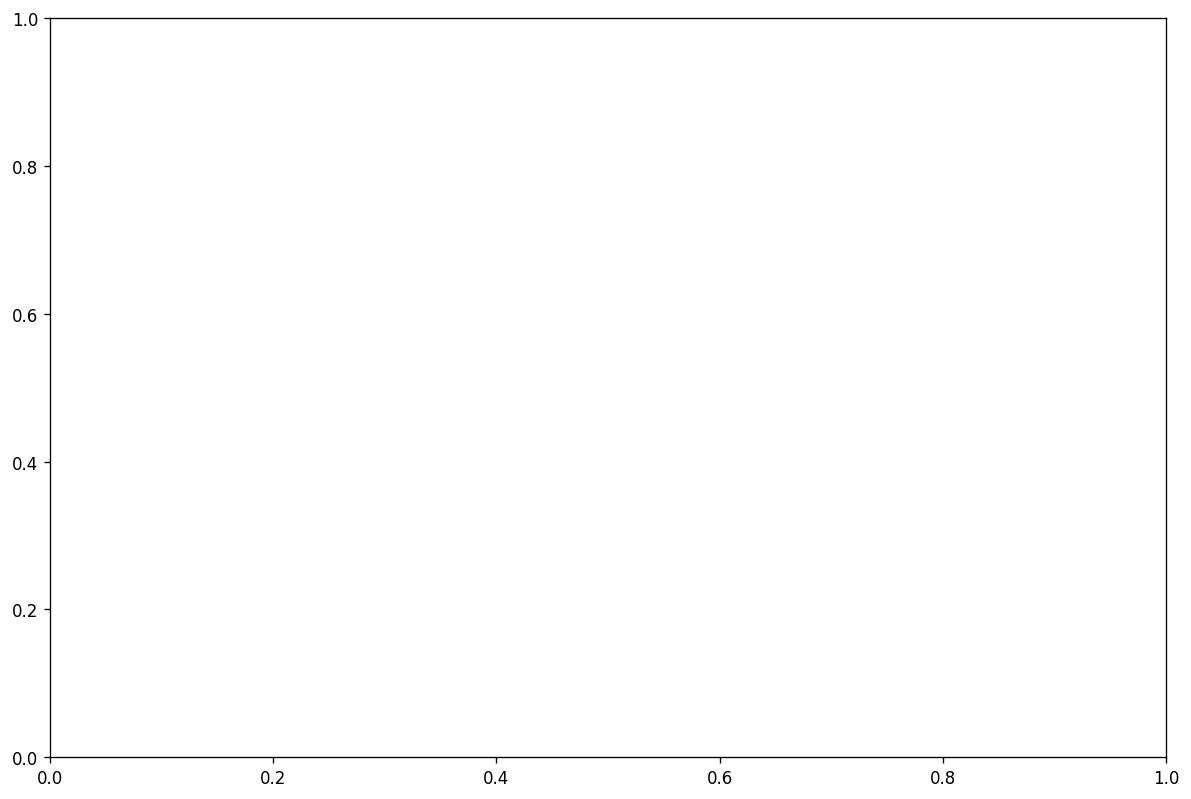

<Figure size 1200x800 with 0 Axes>

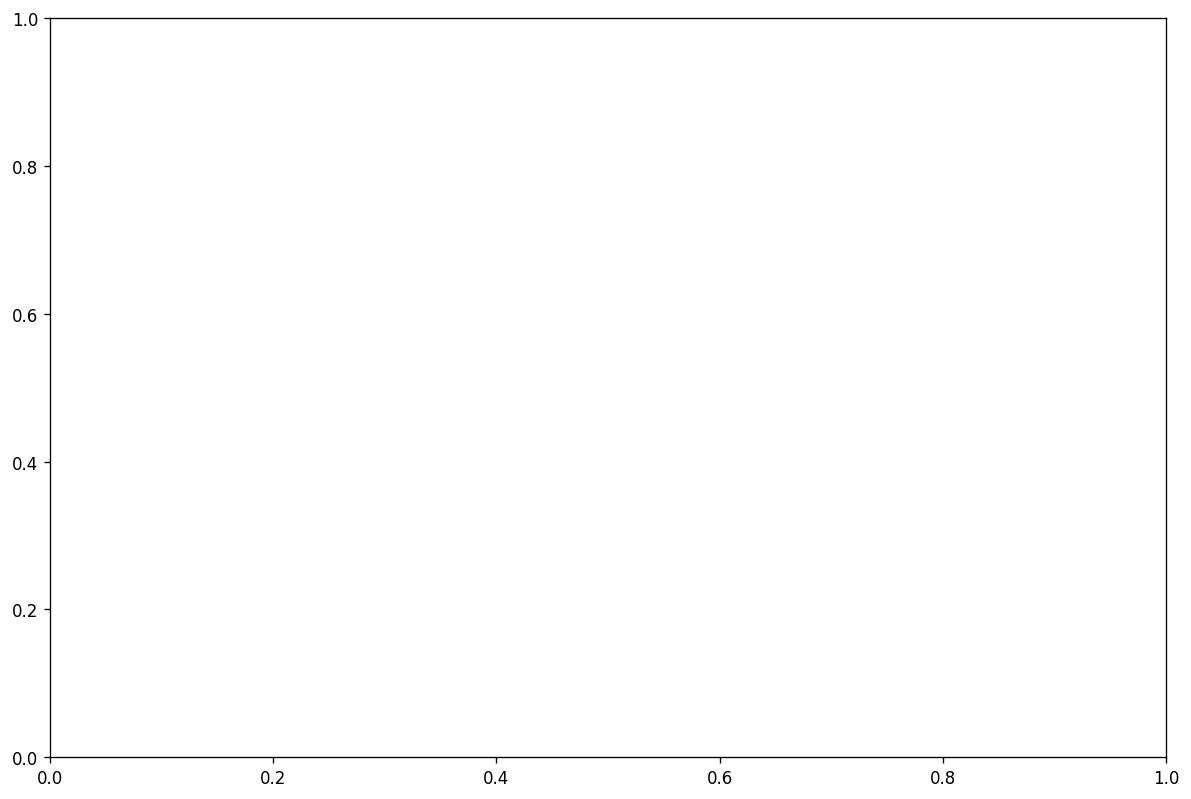

<Figure size 1200x800 with 0 Axes>

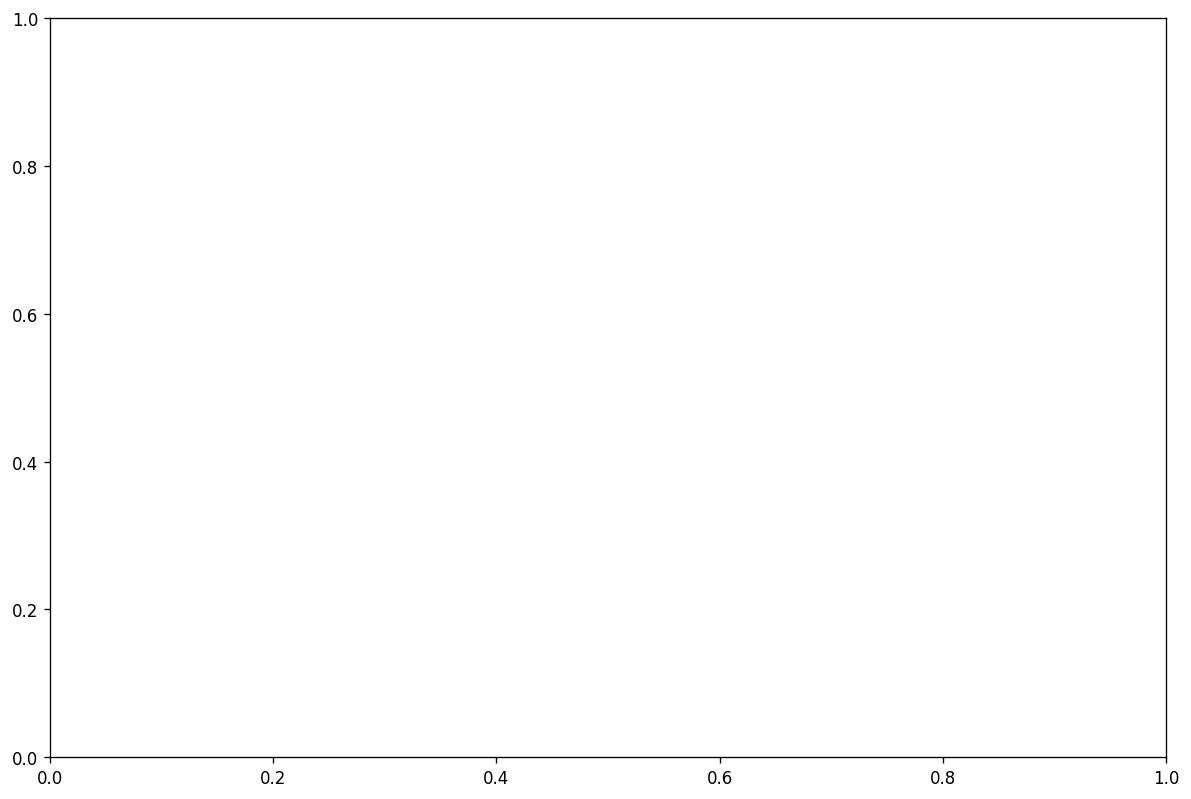

<Figure size 1200x800 with 0 Axes>

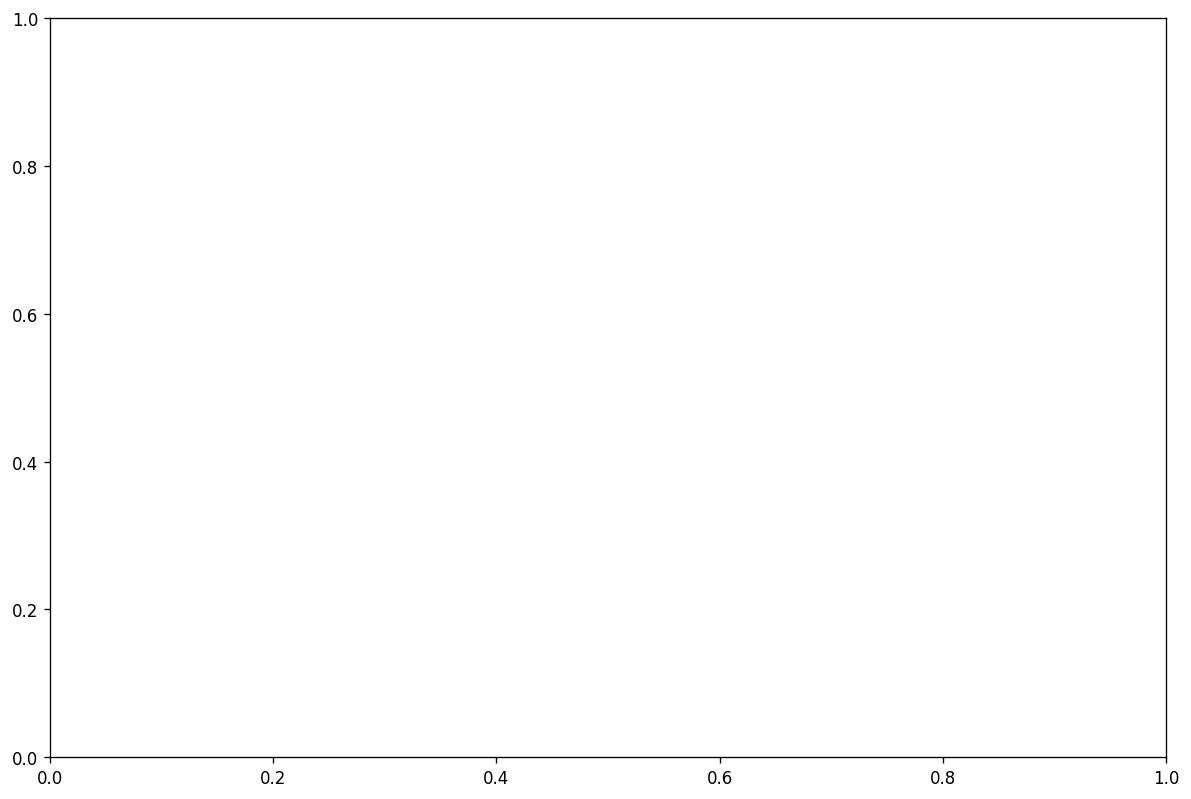

<Figure size 1200x800 with 0 Axes>

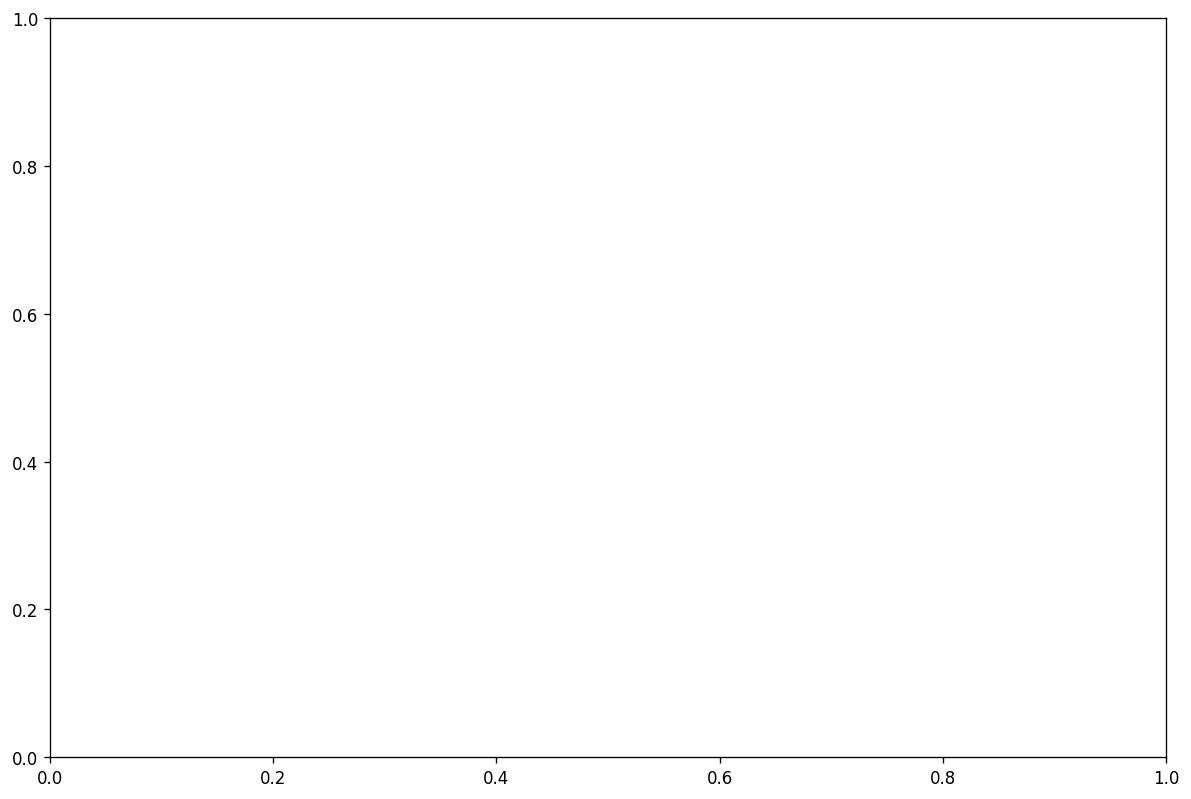

<Figure size 1200x800 with 0 Axes>

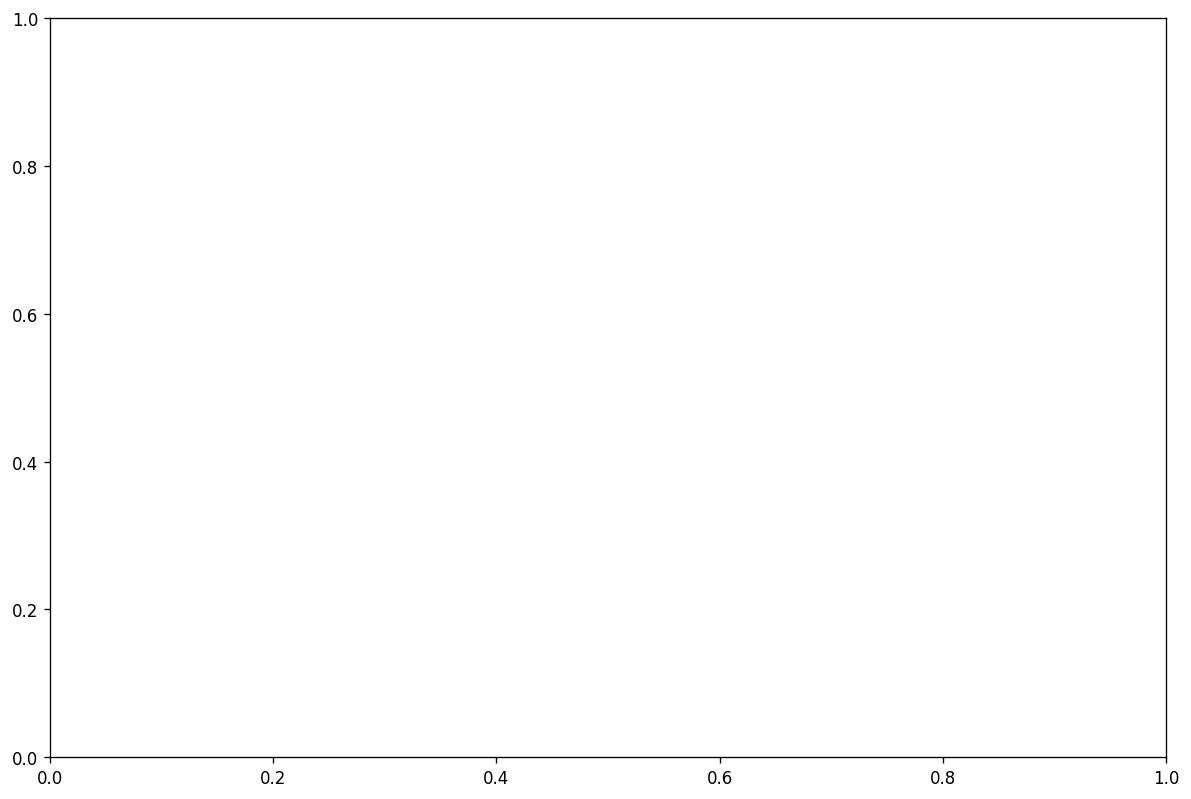

<Figure size 1200x800 with 0 Axes>

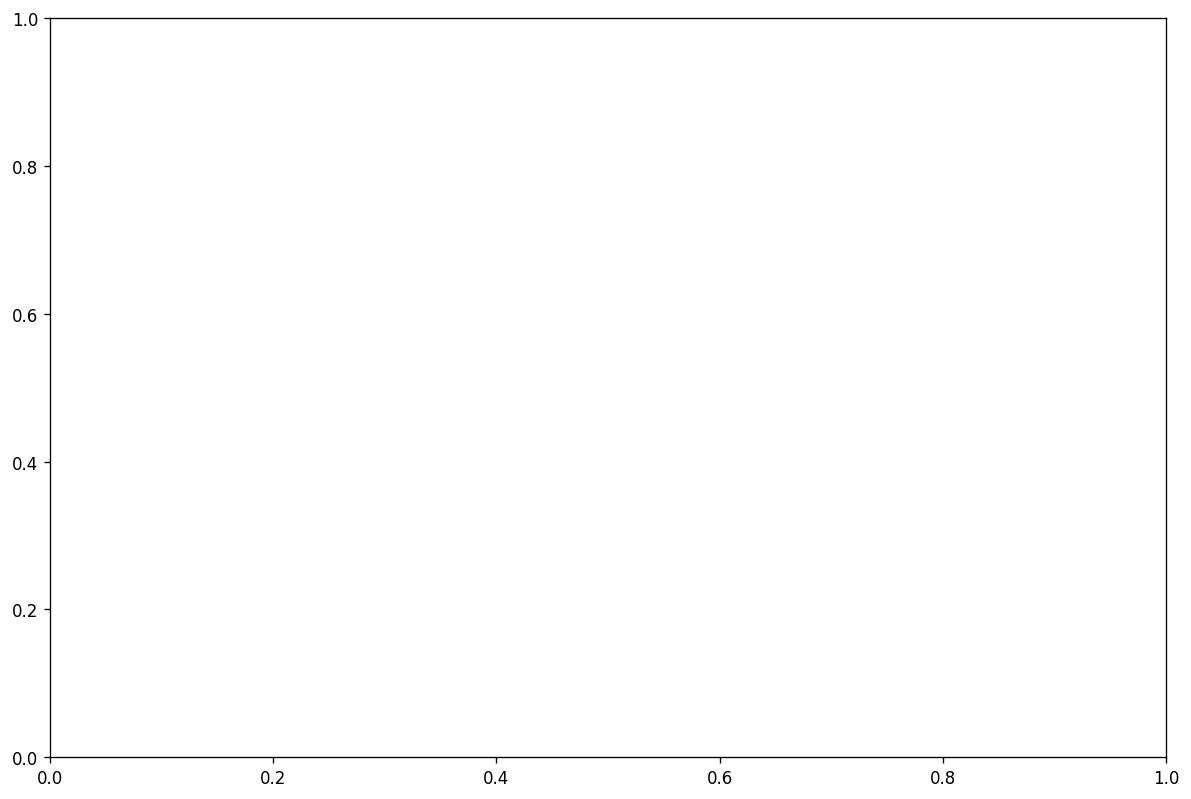

<Figure size 1200x800 with 0 Axes>

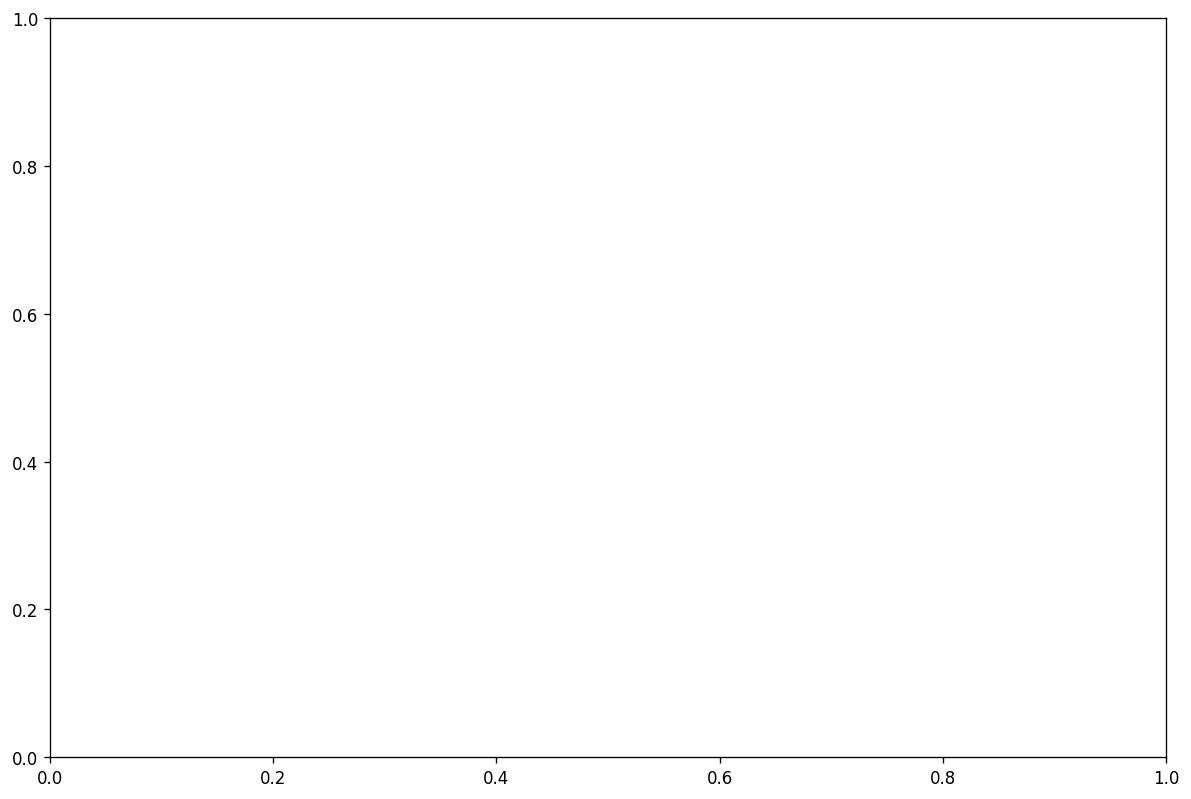

<Figure size 1200x800 with 0 Axes>

In [90]:
for sample in samples:
    if 'BPH' not in sample:
        dat = infercnv_dict[sample].copy()
        dat.obs['cluster'] = dat.obs['sample_id'] + '_' + dat.obs['joint_leiden_clusters']

        # Replace entries with 'ref' if the entry string contains 'BPH', else keep the entry as it was
        dat.obs['cluster'] = ['ref' if 'BPH' in entry else entry for entry in dat.obs['cluster']]

        # Subjective choice of having ther ref plotted alongside (not much to see...)
        dat = dat[dat.obs['cluster']!='ref']
        # Manually clipping the values as a workaround for a bug in the source code
        # as per https://github.com/icbi-lab/infercnvpy/issues/38
        dat.obsm["X_cnv"].data = np.clip(dat.obsm["X_cnv"].data, -0.3, 0.3)

        fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

        cnv.pl.chromosome_heatmap(dat,groupby="cluster", figsize=(12,8),
        show=False)

        plt.savefig('./plots/infercnv_maps_20230808/'+sample+'_infercnv_map.png')
        plt.clf()